In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import matplotlib.backends.backend_pdf

sns.set_theme(color_codes=True)
#sys.path.insert(0, ".././0.data-download/scripts/")

import blitzgsea as blitz


# Download the gene set library here: https://github.com/MaayanLab/blitzgsea


In [2]:
random.seed(18)
seed = random.random()
print(random.random())

0.6614305484952444


In [3]:
# list available gene set libraries in Enrichr
blitz.enrichr.print_libraries()

{'LIBRARY_LIST_URL': 'https://maayanlab.cloud/speedrichr/api/listlibs', 'LIBRARY_DOWNLOAD_URL': 'https://maayanlab.cloud/Enrichr/geneSetLibrary?mode=text&libraryName='}
0 - GeneSigDB
1 - Enrichr_Submissions_TF-Gene_Coocurrence
2 - SysMyo_Muscle_Gene_Sets
3 - WikiPathway_2021_Human
4 - HomoloGene
5 - WikiPathways_2013
6 - PFOCR_Pathways_2023
7 - OMIM_Disease
8 - Data_Acquisition_Method_Most_Popular_Genes
9 - Cancer_Cell_Line_Encyclopedia
10 - WikiPathways_2016
11 - WikiPathways_2015
12 - RNAseq_Automatic_GEO_Signatures_Human_Up
13 - Human_Gene_Atlas
14 - KOMP2_Mouse_Phenotypes_2022
15 - MoTrPAC_2023
16 - Kinase_Perturbations_from_GEO_down
17 - Disease_Signatures_from_GEO_down_2014
18 - Disease_Perturbations_from_GEO_up
19 - Old_CMAP_down
20 - MCF7_Perturbations_from_GEO_up
21 - NIH_Funded_PIs_2017_GeneRIF_ARCHS4_Predictions
22 - DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019
23 - PPI_Hub_Proteins
24 - Disease_Signatures_from_GEO_up_2014
25 - GTEx_Tissue_Expression_Up
26 - L1000_Kinase_a

In [4]:
# use enrichr submodule to retrieve gene set library
# these libraries are finicky to work with--they usually work the first time but then may stop working. You may need to remove the library from your computer and trying to reimport it to work again.
library = blitz.enrichr.get_library("Reactome_2022")

In [5]:
# load the weight matrix 
gene_weight_dir = pathlib.Path("../2.train-VAE/results/weight_matrix_gsea.parquet").resolve()
signature = pd.read_parquet(gene_weight_dir)
print(signature.shape)
signature.head()

(2718, 73)


,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,72
0,AAAS,0.112866,-0.126054,-0.206129,0.044076,-0.127843,0.001078,-0.068105,-0.136596,-0.073931,...,0.112638,-0.002000,0.018558,0.019899,0.023425,-0.047263,-0.023616,0.032459,-0.022189,0.090741
1,AAMP,0.071179,-0.075100,-0.055322,0.048331,0.078016,0.072774,-0.048172,-0.072429,-0.024215,...,0.021369,0.002923,-0.024067,0.002774,0.076762,-0.011417,0.041279,0.118828,0.025779,0.088937
2,AARS1,0.020643,0.157906,0.158789,0.053516,-0.199032,-0.121920,0.031440,0.145072,0.052880,...,-0.057220,-0.000569,0.049257,0.084406,0.127840,-0.059191,0.001083,0.119540,0.032110,0.063436
3,AARS2,0.097258,-0.147074,-0.182926,0.280665,0.292040,0.323171,-0.431678,-0.210640,-0.420061,...,-0.110262,-0.033234,-0.046567,0.001170,0.018983,-0.049473,-0.047729,-0.031597,0.004874,0.015391
4,AASDHPPT,0.302754,0.099287,0.081394,0.341961,0.046994,0.178343,-0.237847,-0.344152,-0.165384,...,-0.093424,-0.115726,-0.036405,-0.130983,-0.039395,-0.150707,-0.082085,0.007228,-0.083000,0.020867


In [6]:
# Running GSEA

all_GSEA_results = []
all_signatures = []
results = []

range = signature.shape[1]

for col in signature.iloc[:,1:range].columns:
    df = signature.iloc[:,[0,int(col)]]
    result = blitz.gsea(df, library, seed=seed)
    results.append(result)
    all_GSEA_results.append(result.assign(z_dim=f"z_{col}"))
    all_signatures.append(df)

In [7]:
# Copying signature dataframe without gene column
neg_signature = signature.iloc[:, 1:].copy()

# Vertically shuffling the data in each column to create a negative control
for col in neg_signature.columns:
    neg_signature.loc[:, col] = np.random.permutation(neg_signature.loc[:, col].values)

# Adding gene column back to finalize negative control data
genes = signature.iloc[:,:1]
neg_signature.insert(0,'0', genes)

# Running GSEA with negative control data
neg_GSEA_results = []
negative_control = []

range = neg_signature.shape[1]

for col in neg_signature.iloc[:,1:range].columns:
    neg_df = neg_signature.iloc[:,[0,int(col)]]
    neg_result = blitz.gsea(neg_df, library, seed=seed)
    neg_GSEA_results.append(neg_result.assign(z_dim=f"z_{col}"))
    negative_control.append(neg_df)

In [8]:
# stack up all of the results to be analyzed
all_GSEA_results= pd.concat(all_GSEA_results)
neg_GSEA_results = pd.concat(neg_GSEA_results)

# merging real and negative control gsea results to single dataframe with column specifying source
all_GSEA_results['source'] = 'real'
neg_GSEA_results['source'] = 'negative control'

combo_gsea_df = pd.concat([all_GSEA_results, neg_GSEA_results])

# saving gsea results as single output file
combo_gsea_dir = pathlib.Path("./results/combined_gsea_results.parquet.gz")
combo_gsea_df.to_parquet(combo_gsea_dir, compression = 'gzip')


In [9]:
# sort by what you want to evaluate
combo_gsea_df.sort_values(by='nes', ascending = True)

,es,nes,pval,sidak,fdr,geneset_size,leading_edge,z_dim,source
Term,,,,,,,,,
M Phase R-HSA-68886,-0.568733,-8.059014,7.691220e-16,7.983487e-13,7.983487e-13,199,"NDC80,PSMD6,PSMB3,INCENP,ANAPC2,PSMA7,CDK1,PSM...",z_18,real
Mitotic Metaphase And Anaphase R-HSA-2555396,-0.631924,-7.892221,2.968548e-15,3.081353e-12,1.540676e-12,147,"NDC80,PSMD6,PSMB3,INCENP,ANAPC2,PSMA7,CDK1,PSM...",z_18,real
M Phase R-HSA-68886,-0.548094,-7.887840,3.074624e-15,3.191460e-12,3.191460e-12,199,"XPO1,RAD21,ANAPC1,NEDD1,AHCTF1,HAUS6,CDCA5,WAP...",z_6,real
Citric Acid (TCA) Cycle And Respiratory Electron Transport R-HSA-1428517,-0.807714,-7.833983,4.726543e-15,4.906152e-12,4.906152e-12,86,"NDUFB6,TIMMDC1,SLC16A1,ATP5F1C,NDUFA3,NDUFB8,C...",z_13,real
Mitotic Anaphase R-HSA-68882,-0.629539,-7.832378,4.787272e-15,4.969189e-12,1.656396e-12,146,"NDC80,PSMD6,PSMB3,INCENP,ANAPC2,PSMA7,CDK1,PSM...",z_18,real
...,...,...,...,...,...,...,...,...,...
"Respiratory Electron Transport, ATP Synthesis By Chemiosmotic Coupling, Heat Production By Uncoupling Proteins R-HSA-163200",0.892508,8.125891,4.189631e-16,4.348837e-13,2.805003e-13,71,"TIMMDC1,UQCRC2,COX4I1,ACAD9,NDUFA3,CYCS,NDUFC1...",z_23,real
Citric Acid (TCA) Cycle And Respiratory Electron Transport R-HSA-1428517,0.845764,8.125891,5.404629e-16,5.610005e-13,2.805003e-13,86,"TIMMDC1,UQCRC2,COX4I1,ACAD9,CYCS,NDUFA3,NDUFC1...",z_23,real
Citric Acid (TCA) Cycle And Respiratory Electron Transport R-HSA-1428517,0.815475,8.209536,2.026577e-16,2.103587e-13,2.103587e-13,86,"UQCRC2,COX5B,NDUFA11,DLST,NDUFB7,NDUFS8,COX6C,...",z_17,real


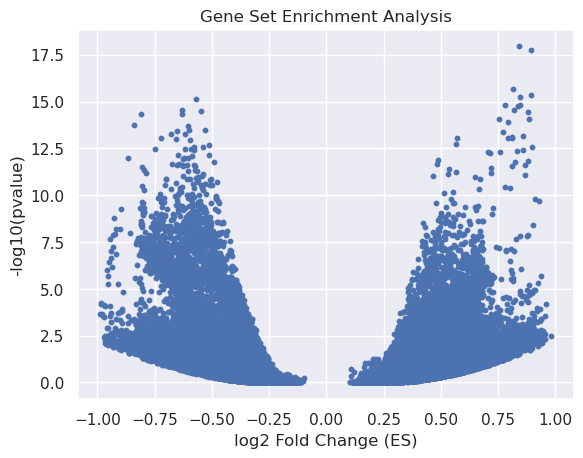

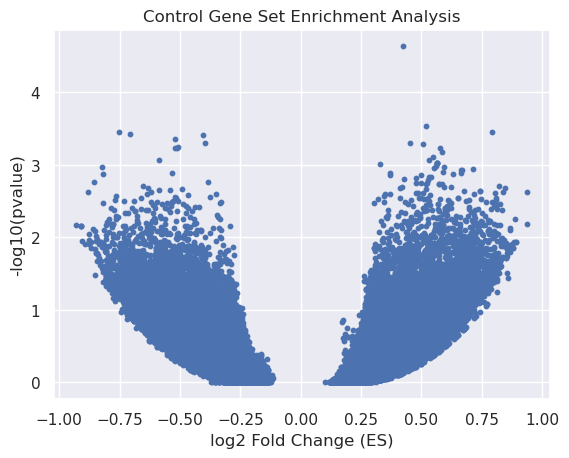

In [10]:
plt.figure()
plt.scatter(x=all_GSEA_results['es'],y=all_GSEA_results['pval'].apply(lambda x:-np.log10(x)),s=10)
plt.xlabel('log2 Fold Change (ES)')
plt.ylabel('-log10(pvalue)')
plt.title('Gene Set Enrichment Analysis')

#save figure
gsea_save_path = pathlib.Path("../1.data-exploration/figures/gsea.png")
plt.savefig(gsea_save_path, bbox_inches="tight", dpi=600)

plt.figure()
plt.scatter(x=neg_GSEA_results['es'],y=neg_GSEA_results['pval'].apply(lambda x:-np.log10(x)), s=10)
plt.xlabel('log2 Fold Change (ES)')
plt.ylabel('-log10(pvalue)')
plt.title('Control Gene Set Enrichment Analysis')

#save figure
cgsea_save_path = pathlib.Path("../1.data-exploration/figures/controlgsea.png")
plt.savefig(cgsea_save_path, bbox_inches="tight", dpi=600)

In [11]:
# Using VAE generated data

pdf_path = pathlib.Path("../1.data-exploration/figures/gsea_plots.pdf")
pdf = matplotlib.backends.backend_pdf.PdfPages(pdf_path)

# Looping over each dataframe in all_signatures to generate gsea plots for the chosen geneset with data 
# from each latent dimension and saving the plots to a singular pdf
for df in all_signatures:
    col_titles = df.columns.tolist()
    dim = col_titles[1]
    z_result = results[int(dim)-1]

    geneset = "Signal Transduction R-HSA-162582"

    text, ax = plt.subplots()
    ax.text(0.5, 0.5, 'The three following figures visualize the gene set enrichment analysis results for ' + geneset + ' in the latent dimension z=' + dim, fontsize=16, ha='center')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    pdf.savefig(text, bbox_inches='tight')
    plt.close()

    fig = blitz.plot.running_sum(df, geneset, library, result=z_result, compact=False)
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()


    fig_compact = blitz.plot.running_sum(df, geneset, library, result=z_result, compact=True)
    pdf.savefig(fig_compact, bbox_inches='tight')
    plt.close()

    fig_table = blitz.plot.top_table(df, library, z_result, n=15)
    pdf.savefig(fig_table, bbox_inches='tight')
    plt.close()

pdf.close()


# Using negative control

ctrl_pdf_path = pathlib.Path("../1.data-exploration/figures/ctrl_gsea_plots.pdf")
ctrl_pdf = matplotlib.backends.backend_pdf.PdfPages(ctrl_pdf_path)

# Looping over each dataframe in negative_control to generate gsea plots for the chosen geneset with data 
# from each latent dimension and saving the plots to a singular pdf
for df in negative_control:
    col_titles = df.columns.tolist()
    dim = col_titles[1]
    z_result = results[int(dim)-1]

    geneset = "Signal Transduction R-HSA-162582"

    text, ax = plt.subplots()
    ax.text(0.5, 0.5, 'The three following figures visualize the negative control gene set enrichment analysis results for ' + geneset + ' in the latent dimension z=' + dim, fontsize=16, ha='center')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    ctrl_pdf.savefig(text, bbox_inches='tight')
    plt.close()

    fig = blitz.plot.running_sum(df, geneset, library, result=z_result, compact=False)
    ctrl_pdf.savefig(fig, bbox_inches='tight')
    plt.close()

    fig_compact = blitz.plot.running_sum(df, geneset, library, result=z_result, compact=True)
    ctrl_pdf.savefig(fig_compact, bbox_inches='tight')
    plt.close()

    fig_table = blitz.plot.top_table(df, library, z_result, n=15)
    ctrl_pdf.savefig(fig_table, bbox_inches='tight')
    plt.close()

ctrl_pdf.close()